In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary  # Overview of the parameters used to print the model
import matplotlib.pyplot as plt

# Print Alerts
print("==> Preparing the dataset...")

# Define data enhancement and preprocessing of training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomized cropping (enhanced data diversity)
    transforms.RandomHorizontalFlip(),     # Random Horizontal Flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # data normalization
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))    # random erase

])

# The test set only needs normalized preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)



==> Preparing the dataset...


In [2]:
class BasicBlock(nn.Module):
    expansion = 1  # The basic block does not expand the number of channels

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer: change size (if stride is not 1) or keep size
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # If input and output sizes don't match, adjust by 1×1 convolution (jump-connected branches)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the main branch and the jump connections
        out = F.relu(out)
        return out


In [16]:
class ResNet_CIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_CIFAR, self).__init__()
        self.in_channels = 64  # The initial number of channels is set to 32
        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Define three stages, each with the number of residual blocks given by num_blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        # Global Average Pooling and Fully Connected Layers
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # The first block may need to be resized, but none after that.
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Define a constructor to construct a smaller ResNet model
def ResNet20():
    return ResNet_CIFAR(BasicBlock, [9, 9, 9])

In [4]:
def train(model, device, trainloader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()         # Gradient zeroing
        outputs = model(inputs)       # forward propagation
        loss = criterion(outputs, targets)
        loss.backward()               # backward propagation
        optimizer.step()              # Updating parameters
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Log output every 100 small batches
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch {epoch}, Step {batch_idx+1}/{len(trainloader)}, Loss: {running_loss/(batch_idx+1):.4f}, Acc: {100.*correct/total:.2f}%')
            
def test(model, device, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient calculation is required for testing
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    avg_loss = test_loss / len(testloader)
    acc = 100. * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%')
    return acc, avg_loss


Use of equipment: cuda
Model structure and number of parameters：
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32

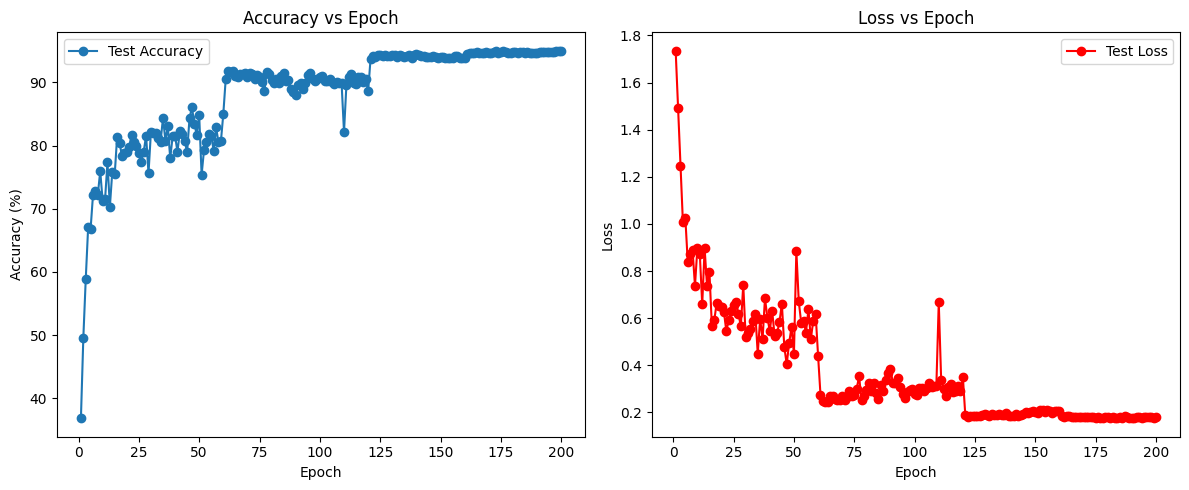

In [5]:
def main():
    # Use GPU (if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Use of equipment:", device)
    
    # Construct the model and transfer it to the specified device
    model = ResNet20().to(device)
    print("Model structure and number of parameters：")
    summary(model, (3, 32, 32))  # Print model parameter information
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
    
    num_epochs = 200  # Set the number of training rounds as needed
    best_acc = 0
    test_acc_list = []  # Used to store test accuracy for each epoch
    test_loss_list = []  # Used to store test losses for each epoch
    
    for epoch in range(1, num_epochs+1):
        train(model, device, trainloader, optimizer, criterion, epoch)
        scheduler.step() # Adjustment of learning rates
        acc, avg_loss = test(model, device, testloader, criterion)
        test_acc_list.append(acc)
        test_loss_list.append(avg_loss)
        # Save the best model (save when test accuracy is highest)
        if acc > best_acc:
            print("Save the best model, current accuracy：{:.2f}%".format(acc))
            best_acc = acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print("End of training, optimal test accuracy：{:.2f}%".format(best_acc))

    # Plotting Accuracy and Loss Curves
    epochs_range = range(1, num_epochs+1)
    plt.figure(figsize=(12, 5))
    
    # Plotting Accuracy Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, test_acc_list, marker='o', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    
    # Plotting Loss Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_loss_list, marker='o', color='red', label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    
    plt.tight_layout()  # Automatic adjustment of subgraph spacing
    plt.show()

if __name__ == "__main__":
    main()

In [10]:
import torch
import pickle
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== 1. Restore model structure (to be exactly as defined during training) =====
model = ResNet20().to(device)
model.load_state_dict(torch.load("/kaggle/input/best_model2/pytorch/default/1/best_model.pth", map_location=device))
model.eval()

# ===== 2. Customize dataset, read .pkl file =====
class CIFARTestDataset(Dataset):
    def __init__(self, pkl_path, transform=None):
        with open(pkl_path, 'rb') as f:
            tmp = pickle.load(f)            # tmp是一个dict，含有 b'data' 和 b'ids'
        self.data = tmp[b'data']           # shape = (10000, 32, 32, 3)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Take out a graph (numpy array, shape=(32, 32, 3))
        img = self.data[idx]
        # Convert to PIL image
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img  # No tags

# ===== 3. Define transforms consistent with training =====
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# ===== 4. Building the DataLoader =====
test_dataset = CIFARTestDataset(
    pkl_path='/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl',
    transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ===== 5. Reasoning and generating submission =====
preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(dim=1)
        preds.extend(predicted.cpu().numpy())

df = pd.DataFrame({
    "id": range(len(preds)),
    "label": preds
})
df.to_csv("submission.csv", index=False)
print("submission.csv saved!")

submission.csv saved!
